In [ ]:
import kagglehub
jahnavimurali_bdd10k_path = kagglehub.dataset_download('jahnavimurali/bdd10k')

print('Data source import complete.',jahnavimurali_bdd10k_path)


100%|██████████| 565M/565M [00:04<00:00, 134MB/s]

Extracting files...


Data source import complete. /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1


# Imports

In [ ]:
import os
import json
import argparse
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

## Constructing the BDD10K dataset for Object Detection

In [ ]:
# labels for object detection (10 classes)
    # person
    # rider
    # car
    # truck
    # bus
    # train
    # motor
    # bike
    # traffic light
    # traffic sign

import json

# Define the classes to retain
target_classes = {"person", "rider", "car", "truck", "bus", "train", "motor", "bike", "traffic light", "traffic sign"}

def filter_labels(input_file, output_file):
    # Open and read the input JSON file
    with open(input_file, 'r') as f:
        data = json.load(f)

    # Initialize a list to store filtered data
    filtered_data = []

    # Process each image's labels
    for item in data:
        filtered_labels = []

        # Filter labels by target classes
        for label in item["labels"]:
            if label["category"] in target_classes:
                # Append only relevant labels to filtered_labels list
                filtered_labels.append(label)

        # If there are any labels for target classes, add them to filtered data
        if filtered_labels:
            item["labels"] = filtered_labels
            filtered_data.append(item)

    # Write the filtered data to the output file
    with open(output_file, 'w') as f:
        json.dump(filtered_data, f, indent=4)


## BDD10K Labels to COCO Labels

In [ ]:
import kagglehub

# Check the download path
bdd10k_path = kagglehub.dataset_download('jahnavimurali/bdd10k')
print("Downloaded to:", bdd10k_path)

# Check files inside the downloaded dataset
print("Contents:", os.listdir(bdd10k_path))

Downloaded to: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1
Contents: ['bdd10k']


In [ ]:
import os

# Define the correct label directory
bdd10k_root = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k"
label_dir = os.path.join(bdd10k_root, "bdd10k_labels")

# Verify it exists
if not os.path.exists(label_dir):
    raise FileNotFoundError(f"Directory not found: {label_dir}")

print("Using label directory:", label_dir)
print("Contents:", os.listdir(label_dir))


Using label directory: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels
Contents: ['bdd10k_labels_train.json', 'bdd10k_labels_val.json']


In [ ]:
import argparse
import json
import os
from tqdm import tqdm


def parse_arguments():
    parser = argparse.ArgumentParser(description='BDD100K to COCO format')
    parser.add_argument(
        "-l", "--label_dir",
        default="/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels",
        help="Root directory of BDD label JSON files",
    )
    parser.add_argument(
        "-s", "--save_path",
        default="/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_coco_labels",
        help="Path to save COCO formatted label file",
    )

    # Filter out Jupyter's auto-passed arguments
    args, _ = parser.parse_known_args()

    # Ensure save directory exists
    os.makedirs(args.save_path, exist_ok=True)

    return args


def bdd2coco_detection(id_dict, labeled_images, fn):
    images = []
    annotations = []
    counter = 0

    for i in tqdm(labeled_images, desc="Processing Images"):
        counter += 1
        image = {
            'file_name': i.get('name', ''),
            'height': 720,
            'width': 1280,
            'id': counter
        }

        empty_image = True
        for l in i.get('labels', []):
            if 'category' in l and l['category'] in id_dict and 'box2d' in l:
                empty_image = False
                annotation = {
                    "iscrowd": 0,
                    "image_id": image['id'],
                    "bbox": [
                        l['box2d']['x1'], l['box2d']['y1'],
                        l['box2d']['x2'] - l['box2d']['x1'],
                        l['box2d']['y2'] - l['box2d']['y1']
                    ],
                    "area": float((l['box2d']['x2'] - l['box2d']['x1']) * (l['box2d']['y2'] - l['box2d']['y1'])),
                    "category_id": id_dict[l['category']],
                    "ignore": 0,
                    "id": l.get('id', counter),
                    "segmentation": [[
                        l['box2d']['x1'], l['box2d']['y1'],
                        l['box2d']['x1'], l['box2d']['y2'],
                        l['box2d']['x2'], l['box2d']['y2'],
                        l['box2d']['x2'], l['box2d']['y1']
                    ]]
                }
                annotations.append(annotation)

        if not empty_image:
            images.append(image)

    coco_format = {
        "categories": attr_dict["categories"],
        "images": images,
        "annotations": annotations,
        "type": "instances"
    }

    print(f"Saving COCO formatted labels to {fn}")
    with open(fn, "w") as file:
        json.dump(coco_format, file, indent=4)


if __name__ == '__main__':
    args = parse_arguments()

    attr_dict = {
        "categories": [
            {"supercategory": "none", "id": 0, "name": "person"},
            {"supercategory": "none", "id": 1, "name": "rider"},
            {"supercategory": "none", "id": 2, "name": "car"},
            {"supercategory": "none", "id": 3, "name": "truck"},
            {"supercategory": "none", "id": 4, "name": "bus"},
            {"supercategory": "none", "id": 5, "name": "train"},
            {"supercategory": "none", "id": 6, "name": "motor"},
            {"supercategory": "none", "id": 7, "name": "bike"},
            {"supercategory": "none", "id": 8, "name": "traffic light"},
            {"supercategory": "none", "id": 9, "name": "traffic sign"}
        ]
    }

    attr_id_dict = {i['name']: i['id'] for i in attr_dict['categories']}
    print("Category ID mapping:", attr_id_dict)

    # Process training set
    train_file = os.path.join(args.label_dir, 'bdd10k_labels_train.json')
    if os.path.exists(train_file):
        print("Loading training set...")
        with open(train_file) as f:
            train_labels = json.load(f)
        print("Converting training set...")
        bdd2coco_detection(attr_id_dict, train_labels, os.path.join(args.save_path, 'bdd10k_coco_labels_train.json'))
    else:
        print(f"Warning: Training label file not found at {train_file}")

    # Process validation set
    val_file = os.path.join(args.label_dir, 'bdd10k_labels_val.json')
    if os.path.exists(val_file):
        print("Loading validation set...")
        with open(val_file) as f:
            val_labels = json.load(f)
        print("Converting validation set...")
        bdd2coco_detection(attr_id_dict, val_labels, os.path.join(args.save_path, 'bdd10k_coco_labels_val.json'))
    else:
        print(f"Warning: Validation label file not found at {val_file}")


## BDD10K to YOLO Annotations

In [ ]:
import os
import json

# Define the target classes and assign class IDs
target_classes = ["person", "rider", "car", "truck", "bus", "train", "motor", "bike", "traffic light", "traffic sign"]
class_map = {cls: i for i, cls in enumerate(target_classes)}

def convert_filtered_bdd_to_yolo(input_json_path, output_label_dir, img_width, img_height):
    # Check if the annotation file exists
    if not os.path.exists(input_json_path):
        print(f"Warning: Annotation file not found at {input_json_path}")
        return

    # Load the already filtered JSON annotations
    with open(input_json_path, 'r') as f:
        data = json.load(f)

    # Ensure output directory exists
    os.makedirs(output_label_dir, exist_ok=True)

    # Process each annotation
    for item in data:
        image_name = item.get('name', '')
        if not image_name:
            continue  # Skip if image name is missing

        image_id = os.path.splitext(image_name)[0]

        # Open a YOLO annotation file for each image
        label_file_path = os.path.join(output_label_dir, f"{image_id}.txt")
        with open(label_file_path, 'w') as label_file:
            for label in item.get('labels', []):
                category = label.get('category', '')
                if category not in class_map or 'box2d' not in label:
                    continue  # Skip if category is not in target classes or missing box2d

                class_id = class_map[category]

                # Convert bounding box coordinates to YOLO format (normalize coordinates)
                box = label["box2d"]
                x_center = ((box["x1"] + box["x2"]) / 2.0) / img_width
                y_center = ((box["y1"] + box["y2"]) / 2.0) / img_height
                width = (box["x2"] - box["x1"]) / img_width
                height = (box["y2"] - box["y1"]) / img_height

                label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"Converted YOLO labels saved to: {output_label_dir}")


# **Updated Dataset Paths for Kaggle**
label_dir = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels"
output_train_labels = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/train"
output_val_labels = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/val"

# Image dimensions
img_width = 1280
img_height = 720

# Convert labels to YOLO format
convert_filtered_bdd_to_yolo(os.path.join(label_dir, "bdd10k_labels_train.json"), output_train_labels, img_width, img_height)
convert_filtered_bdd_to_yolo(os.path.join(label_dir, "bdd10k_labels_val.json"), output_val_labels, img_width, img_height)


Converted YOLO labels saved to: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/train
Converted YOLO labels saved to: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/val


# Loading Data

In [ ]:
import os

# Updated dataset paths for Kaggle
train_folder = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/images/train"
val_folder = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/images/val"
test_folder = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/images/test"

# Function to count files safely
def count_files(folder_path):
    if os.path.exists(folder_path):
        return len(os.listdir(folder_path))
    else:
        print(f"Warning: Folder not found -> {folder_path}")
        return 0  # Return 0 if the folder does not exist

# Print dataset statistics
print(f"Train Folder: {count_files(train_folder)} images")
print(f"Validation Folder: {count_files(val_folder)} images")
print(f"Test Folder: {count_files(test_folder)} images")


Train Folder: 7000 images
Validation Folder: 1000 images
Test Folder: 2000 images


In [ ]:
import os

# Correct dataset paths
train_bdd10k_labels_json = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels/bdd10k_labels_train.json"
val_bdd10k_labels_json = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels/bdd10k_labels_val.json"

# Function to check if JSON files exist
def check_file(path):
    if os.path.exists(path):
        print(f"✅ Found: {path}")
    else:
        print(f"❌ Warning: File not found -> {path}")

# Check both JSON files
check_file(train_bdd10k_labels_json)
check_file(val_bdd10k_labels_json)


✅ Found: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels/bdd10k_labels_train.json
✅ Found: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k_labels/bdd10k_labels_val.json


In [ ]:
import pandas as pd

# Load JSON files into DataFrames
df_train = pd.read_json(train_bdd10k_labels_json)
df_val = pd.read_json(val_bdd10k_labels_json)

# Display first few rows (uncomment if needed)
# print(df_train.head())

# Check the structure of the dataset
print("Train JSON structure:", df_train.columns)
print("Validation JSON structure:", df_val.columns)

# Check sample annotations
print("Sample train annotations:", df_train.iloc[0])


Train JSON structure: Index(['name', 'attributes', 'timestamp', 'labels'], dtype='object')
Validation JSON structure: Index(['name', 'attributes', 'timestamp', 'labels'], dtype='object')
Sample train annotations: name                                      0000f77c-6257be58.jpg
attributes    {'weather': 'clear', 'scene': 'city street', '...
timestamp                                                 10000
labels        [{'category': 'traffic light', 'attributes': {...
Name: 0, dtype: object


# Exploratory Data Analysis

## Checking for missing values

In [ ]:
# Check for missing values
print("Train: \n", df_train.isnull().sum())
print()
print("Validation: \n", df_train.isnull().sum())

Train: 
 name          0
attributes    0
timestamp     0
labels        0
dtype: int64

Validation: 
 name          0
attributes    0
timestamp     0
labels        0
dtype: int64


## Understanding weather scene and time of day distribution

In [ ]:
# Extract 'weather' and 'scene' from the 'attributes' column
print("Train")
weather_counts_train = df_train['attributes'].apply(lambda x: x['weather']).value_counts()
daytime_counts_train = df_train['attributes'].apply(lambda x:x['timeofday']).value_counts()
scene_counts_train = df_train['attributes'].apply(lambda x: x['scene']).value_counts()

print("Weather Distribution:\n", weather_counts_train)
print("\nDay Time Distribution:\n", daytime_counts_train)
print("\nScene Distribution:\n", scene_counts_train)
print()


print("Validation")
weather_counts_val = df_val['attributes'].apply(lambda x: x['weather']).value_counts()
daytime_counts_val = df_val['attributes'].apply(lambda x:x['timeofday']).value_counts()
scene_counts_val = df_val['attributes'].apply(lambda x: x['scene']).value_counts()

print("Weather Distribution:\n", weather_counts_val)
print("\nDay Time Distribution:\n", daytime_counts_train)
print("\nScene Distribution:\n", scene_counts_val)


Train
Weather Distribution:
 attributes
clear            3739
overcast          905
undefined         803
snowy             535
partly cloudy     522
rainy             489
foggy               7
Name: count, dtype: int64

Day Time Distribution:
 attributes
daytime      3752
night        2729
dawn/dusk     510
undefined       9
Name: count, dtype: int64

Scene Distribution:
 attributes
city street     4311
highway         1752
residential      850
parking lot       45
undefined         28
tunnel            12
gas stations       2
Name: count, dtype: int64

Validation
Weather Distribution:
 attributes
clear            544
overcast         126
undefined        117
snowy             73
partly cloudy     72
rainy             67
foggy              1
Name: count, dtype: int64

Day Time Distribution:
 attributes
daytime      3752
night        2729
dawn/dusk     510
undefined       9
Name: count, dtype: int64

Scene Distribution:
 attributes
city street     600
highway         266
residential   

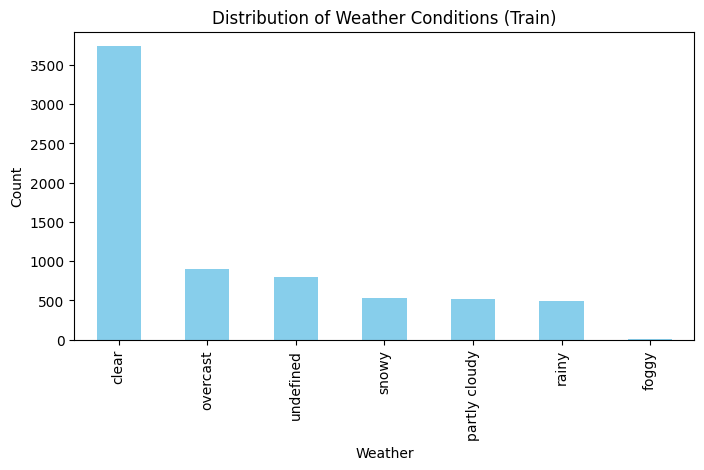

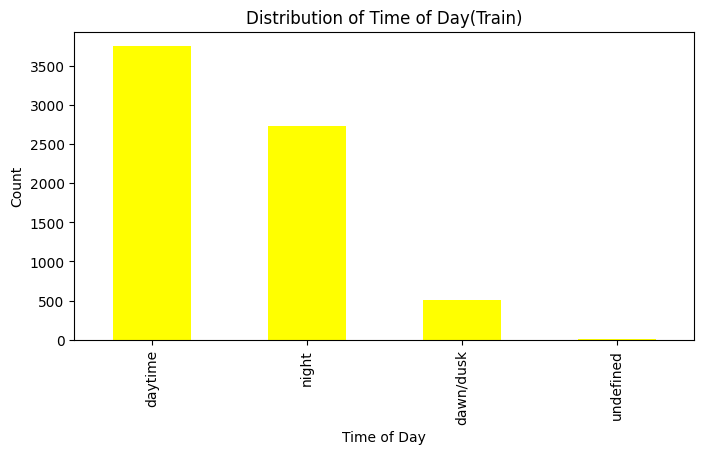

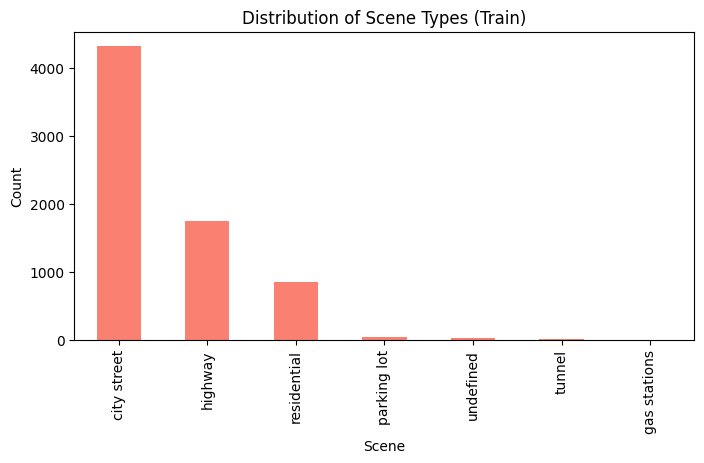

In [ ]:
# Plot weather distribution
plt.figure(figsize=(8, 4))
weather_counts_train.plot(kind='bar', color='skyblue')
plt.title('Distribution of Weather Conditions (Train)')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.show()

# Plot Time of Day distribution
plt.figure(figsize=(8, 4))
daytime_counts_train.plot(kind='bar', color='yellow')
plt.title('Distribution of Time of Day(Train)')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.show()


# Plot scene distribution
plt.figure(figsize=(8, 4))
scene_counts_train.plot(kind='bar', color='salmon')
plt.title('Distribution of Scene Types (Train)')
plt.xlabel('Scene')
plt.ylabel('Count')
plt.show()


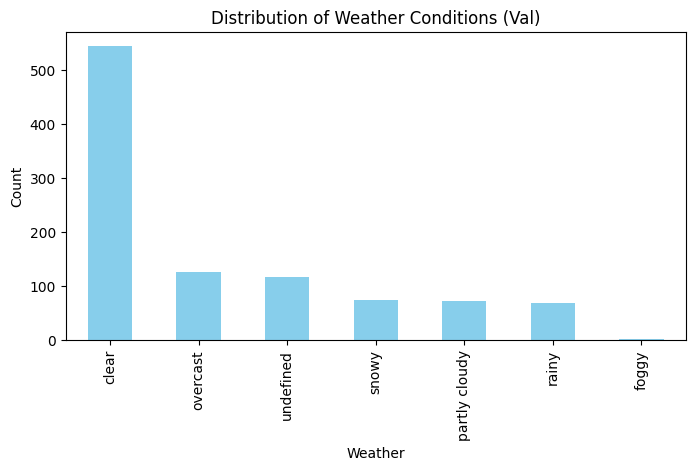

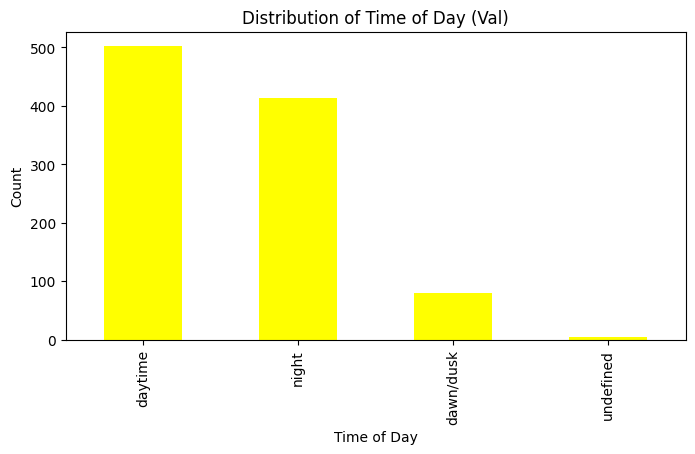

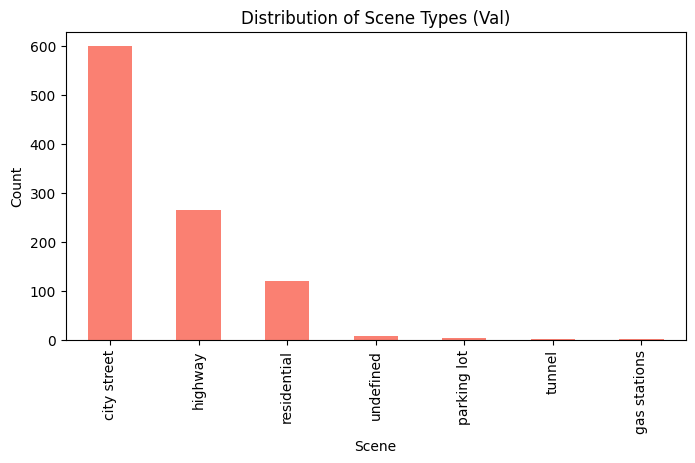

In [ ]:
# Plot weather distribution
plt.figure(figsize=(8, 4))
weather_counts_val.plot(kind='bar', color='skyblue')
plt.title('Distribution of Weather Conditions (Val)')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.show()

# Plot Time of Day distribution
plt.figure(figsize=(8, 4))
daytime_counts_val.plot(kind='bar', color='yellow')
plt.title('Distribution of Time of Day (Val)')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.show()


# Plot scene distribution
plt.figure(figsize=(8, 4))
scene_counts_val.plot(kind='bar', color='salmon')
plt.title('Distribution of Scene Types (Val)')
plt.xlabel('Scene')
plt.ylabel('Count')
plt.show()


# Number of occurences of each class in the dataset

In [ ]:
#created function to extract 'category' from labels' column in each row
def clean_labels(example):
  """
  Extracting 'category' from each row and adding unique words to a list.

  Parameters:
  ----------
      example: dataframe column map function
              df['labels'].map(clean_labels)

  Returns:
  -------
      a list of unique words separated by a comma

  """
  example_df = pd.DataFrame.from_records(example)
  example_df = example_df['category'].unique().tolist()
  return ','.join(example_df)


#created a new column which runs the above function on the labels column
df_train['clean_labels'] = df_train['labels'].map(clean_labels)


#observing df_train with new columm
df_train

,name,attributes,timestamp,labels,clean_labels
0,0000f77c-6257be58.jpg,"{'weather': 'clear', 'scene': 'city street', '...",10000,"[{'category': 'traffic light', 'attributes': {...","traffic light,traffic sign,car"
1,0000f77c-62c2a288.jpg,"{'weather': 'clear', 'scene': 'highway', 'time...",10000,"[{'category': 'traffic sign', 'attributes': {'...","traffic sign,person"
2,0000f77c-cb820c98.jpg,"{'weather': 'clear', 'scene': 'residential', '...",10000,"[{'category': 'car', 'attributes': {'occluded'...",car
3,0001542f-5ce3cf52.jpg,"{'weather': 'clear', 'scene': 'city street', '...",10000,"[{'category': 'traffic sign', 'attributes': {'...","traffic sign,traffic light,car,bus"
4,0001542f-7c670be8.jpg,"{'weather': 'clear', 'scene': 'highway', 'time...",10000,"[{'category': 'car', 'attributes': {'occluded'...","car,person,traffic light,traffic sign"
...,...,...,...,...,...
6995,122af8db-449e73c0.jpg,"{'weather': 'clear', 'scene': 'highway', 'time...",10000,"[{'category': 'car', 'attributes': {'occluded'...","car,traffic sign"
6996,122af8db-bbe0f348.jpg,"{'weather': 'clear', 'scene': 'city street', '...",10000,"[{'category': 'traffic sign', 'attributes': {'...","traffic sign,bus,car,truck,person,traffic light"
6997,122af8db-cb182f78.jpg,"{'weather': 'clear', 'scene': 'city street', '...",10000,"[{'category': 'traffic sign', 'attributes': {'...","traffic sign,traffic light,car,truck"
6998,122b2ffe-4e84c9ec.jpg,"{'weather': 'clear', 'scene': 'city street', '...",10000,"[{'category': 'car', 'attributes': {'occluded'...","car,bus,motor"


In [ ]:
data_train = df_train.copy()
for target in target_classes:
    data_train[target] = data_train['clean_labels'].str.contains(target)
    data_train[target] = data_train[target].astype(int)
#drop attributes and timestamp columns, not neccessary for our model
columns = ['attributes', 'timestamp']
data_train = data_train.drop(columns = columns)

In [ ]:
data_train.head()

,name,labels,clean_labels,person,rider,car,truck,bus,train,motor,bike,traffic light,traffic sign
0,0000f77c-6257be58.jpg,"[{'category': 'traffic light', 'attributes': {...","traffic light,traffic sign,car",0,0,1,0,0,0,0,0,1,1
1,0000f77c-62c2a288.jpg,"[{'category': 'traffic sign', 'attributes': {'...","traffic sign,person",1,0,0,0,0,0,0,0,0,1
2,0000f77c-cb820c98.jpg,"[{'category': 'car', 'attributes': {'occluded'...",car,0,0,1,0,0,0,0,0,0,0
3,0001542f-5ce3cf52.jpg,"[{'category': 'traffic sign', 'attributes': {'...","traffic sign,traffic light,car,bus",0,0,1,0,1,0,0,0,1,1
4,0001542f-7c670be8.jpg,"[{'category': 'car', 'attributes': {'occluded'...","car,person,traffic light,traffic sign",1,0,1,0,0,0,0,0,1,1


In [ ]:
labels = list(data_train.columns.values)
labels = labels[3:]
print(labels)

#creating dataframe
counts = []
for label in labels:
    counts.append((label, data_train[label].sum()))
df_stats = pd.DataFrame(counts, columns=['Labels', 'Occurrence'])
df_stats = df_stats.sort_values(['Occurrence']).reset_index(drop=True)
df_stats

['person', 'rider', 'car', 'truck', 'bus', 'train', 'motor', 'bike', 'traffic light', 'traffic sign']


,Labels,Occurrence
0,train,10
1,motor,230
2,rider,365
3,bike,443
4,bus,895
5,truck,1912
6,person,2211
7,traffic light,3989
8,traffic sign,5743
9,car,6923


# Perception Models

## YOLO V11 Large Model

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model (you can change "yolov8l.pt" to "yolov8n.pt", "yolov8m.pt", etc.)
model = YOLO("yolov8l.pt")

# Train the model on BDD100K
model.train(
    data="/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k.yaml",
    epochs=50,
    batch=16,
    imgsz=448  # Match your training image size
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:00<00:00, 259MB/s]


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/bdd10k.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=448, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

100%|██████████| 755k/755k [00:00<00:00, 22.9MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.3MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/train... 7000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7000/7000 [00:12<00:00, 566.92it/s]


train: New cache created: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/val... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 505.95it/s]


val: New cache created: /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 448 train, 448 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.45G      1.328      1.069      1.021        274        448: 100%|██████████| 438/438 [03:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


                   all       1000      18290      0.547      0.225       0.22      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.22G      1.403     0.9469      1.047        310        448: 100%|██████████| 438/438 [03:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


                   all       1000      18290      0.364      0.206      0.199        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.26G      1.413     0.9461      1.051        252        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


                   all       1000      18290      0.413      0.238      0.222       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.14G      1.384     0.9102      1.037        208        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


                   all       1000      18290      0.576      0.217      0.216      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.17G      1.356     0.8765      1.027        279        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


                   all       1000      18290      0.355      0.256      0.244      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.28G      1.331     0.8541      1.018        213        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


                   all       1000      18290      0.471      0.295      0.271      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.18G      1.312     0.8283      1.009        248        448: 100%|██████████| 438/438 [03:13<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


                   all       1000      18290      0.446      0.275      0.267      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.29G       1.29     0.8064          1        233        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


                   all       1000      18290      0.584      0.272      0.298      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.33G      1.282     0.7933     0.9944        261        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all       1000      18290      0.437      0.296      0.294      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.28G       1.27     0.7844      0.993        222        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


                   all       1000      18290      0.481       0.27      0.288       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.21G      1.257     0.7692     0.9877        211        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.11it/s]


                   all       1000      18290      0.572      0.311      0.307      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.29G      1.249     0.7623     0.9851        289        448: 100%|██████████| 438/438 [03:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all       1000      18290      0.507      0.326      0.318      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.33G      1.232     0.7456     0.9782        332        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all       1000      18290      0.548      0.308      0.318      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.29G      1.226     0.7404     0.9758        339        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


                   all       1000      18290       0.42      0.321      0.317      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.18G      1.225     0.7305     0.9727        227        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


                   all       1000      18290      0.461      0.333      0.335       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.27G      1.208     0.7199     0.9699        205        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all       1000      18290      0.553      0.329      0.333      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.23G      1.209     0.7142     0.9673        240        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all       1000      18290      0.572      0.359      0.346      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.18G      1.199     0.7076     0.9668        308        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all       1000      18290      0.545       0.35      0.344      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.19G      1.191     0.6949     0.9631        237        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


                   all       1000      18290      0.568       0.36      0.361      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.16G      1.182     0.6888     0.9588        312        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


                   all       1000      18290      0.567      0.358      0.354       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.21G      1.182      0.686     0.9582        341        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


                   all       1000      18290      0.548      0.354      0.354      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.19G      1.174     0.6849     0.9555        256        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all       1000      18290      0.619      0.346      0.368      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       5.3G      1.163     0.6711     0.9529        201        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


                   all       1000      18290      0.585      0.342      0.359      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.17G      1.162     0.6636     0.9485        201        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


                   all       1000      18290      0.573      0.358      0.372      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.31G      1.156     0.6629     0.9513        174        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


                   all       1000      18290      0.567      0.384      0.378      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.15G      1.151     0.6526     0.9473        212        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all       1000      18290      0.617      0.361      0.375      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.38G      1.142     0.6459     0.9453        214        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


                   all       1000      18290      0.591      0.387      0.394       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.27G      1.136     0.6403     0.9428        223        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all       1000      18290      0.588      0.391      0.388      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.36G      1.133     0.6342     0.9408        243        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


                   all       1000      18290      0.618      0.352      0.381      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.18G      1.128     0.6304     0.9411        259        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


                   all       1000      18290      0.594      0.363      0.382      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.29G      1.121     0.6249     0.9364        251        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


                   all       1000      18290      0.627      0.372      0.391      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.19G      1.122      0.622     0.9344        236        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


                   all       1000      18290       0.64      0.373        0.4      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.21G       1.11     0.6125     0.9356        298        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


                   all       1000      18290      0.643      0.369      0.395      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.25G      1.112     0.6116     0.9341        184        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all       1000      18290      0.625      0.372      0.393       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.29G      1.105     0.6076     0.9309        261        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


                   all       1000      18290      0.615      0.385      0.403      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.28G      1.098     0.5978     0.9305        203        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


                   all       1000      18290      0.625      0.383      0.409      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.3G      1.095     0.5923     0.9275        339        448: 100%|██████████| 438/438 [03:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.11it/s]


                   all       1000      18290      0.601      0.394      0.402      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.19G       1.09     0.5889     0.9269        313        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


                   all       1000      18290      0.611      0.375      0.403      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.18G       1.08     0.5802     0.9253        372        448: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


                   all       1000      18290       0.65      0.384      0.404      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.29G      1.079     0.5782     0.9207        214        448: 100%|██████████| 438/438 [03:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


                   all       1000      18290      0.615      0.393      0.404      0.225
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.34G      1.121     0.5773     0.9233        114        448: 100%|██████████| 438/438 [03:13<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


                   all       1000      18290      0.644      0.379      0.395      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.33G      1.109     0.5667     0.9207         96        448: 100%|██████████| 438/438 [03:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


                   all       1000      18290      0.662      0.372      0.407      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.36G      1.107     0.5633     0.9191        167        448: 100%|██████████| 438/438 [03:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


                   all       1000      18290      0.633      0.381      0.404      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.34G      1.101     0.5606     0.9175        153        448: 100%|██████████| 438/438 [03:11<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


                   all       1000      18290      0.642      0.386      0.413      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.35G      1.093     0.5532     0.9147        133        448: 100%|██████████| 438/438 [03:11<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


                   all       1000      18290      0.656      0.385      0.406      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.32G      1.088     0.5476     0.9157        167        448: 100%|██████████| 438/438 [03:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


                   all       1000      18290      0.662      0.369      0.406      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.35G      1.089     0.5433     0.9152        157        448: 100%|██████████| 438/438 [03:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


                   all       1000      18290      0.631      0.383      0.405      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.35G      1.082     0.5404     0.9115        118        448: 100%|██████████| 438/438 [03:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all       1000      18290      0.643      0.383      0.409      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.35G      1.076     0.5339     0.9095        142        448: 100%|██████████| 438/438 [03:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


                   all       1000      18290      0.644      0.383      0.408      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       5.3G      1.076     0.5324     0.9099        165        448: 100%|██████████| 438/438 [03:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


                   all       1000      18290      0.642      0.387      0.411      0.227

50 epochs completed in 2.969 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


                   all       1000      18290      0.642      0.386      0.412      0.227
                person        325       1234      0.648      0.436      0.483      0.226
                 rider         48         60      0.575      0.383      0.383      0.201
                   car        987       9987      0.752      0.649      0.704      0.439
                 truck        268        416      0.578        0.5       0.52      0.364
                   bus        133        170      0.608      0.447      0.475       0.34
                 train          1          2          1          0          0          0
                 motor         28         39      0.527      0.385      0.433      0.196
                  bike         65        111      0.402      0.243      0.216       0.11
         traffic light        566       2740      0.665      0.381       0.43      0.152
          traffic sign        811       3531      0.664      0.436      0.478      0.245
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a237726b890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0


image 1/1 /root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/images/test/cdaee377-2b38ae2c.jpg: 384x640 2 persons, 1 bicycle, 7 cars, 1 truck, 2 traffic lights, 40.9ms
Speed: 4.3ms preprocess, 40.9ms inference, 21.7ms postprocess per image at shape (1, 3, 384, 640)


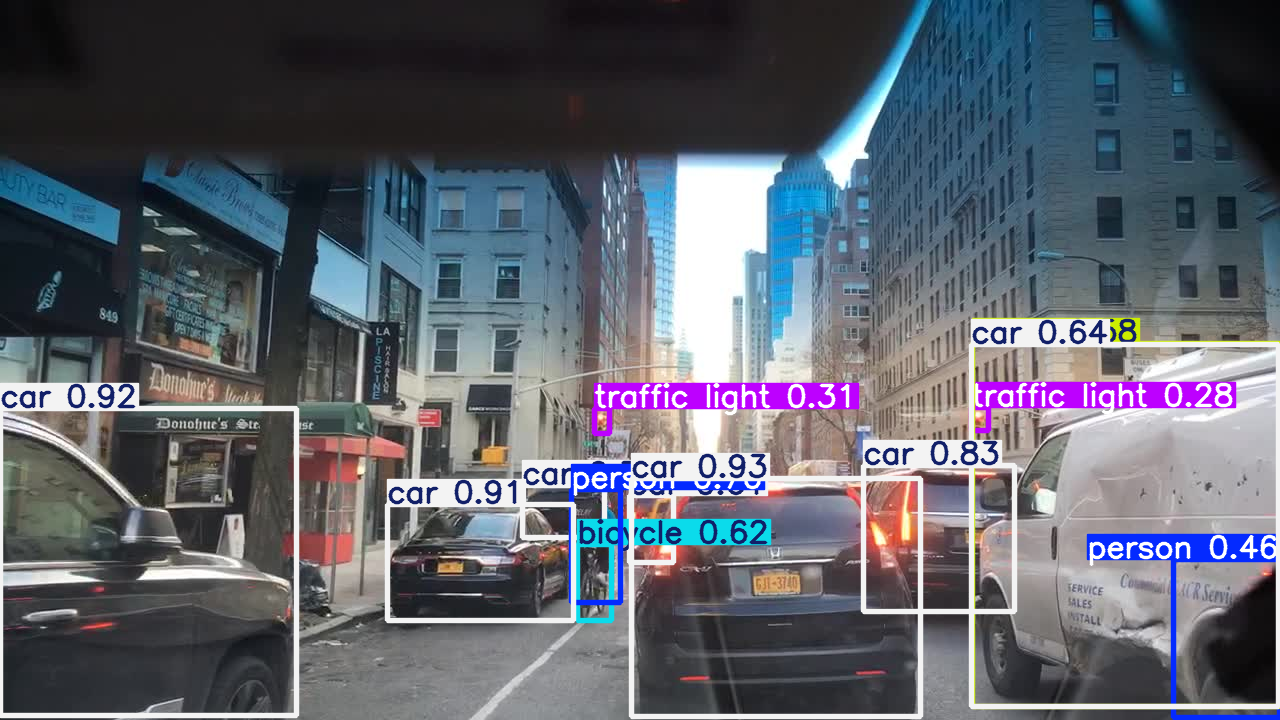

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model (change to "yolov8l.pt" if needed)
model = YOLO("yolov8l.pt")

# Define the test image path (modify if needed)
test_image = "/root/.cache/kagglehub/datasets/jahnavimurali/bdd10k/versions/1/bdd10k/images/test/cdaee377-2b38ae2c.jpg"

# Run inference on the test image
results = model(test_image)

# Display and save results
for result in results:
    result.show()
    result.save(filename="result.jpg")


In [ ]:
import torch
# Save the trained model
saved_model_path = "yolov8_bdd100k.pt"
model.export(format="torchscript")  # Save as TorchScript
torch.save(model.model.state_dict(), saved_model_path)

# Export to ONNX and TensorRT
onnx_model_path = "yolov8_bdd100k.onnx"
tensorrt_model_path = "yolov8_bdd100k.engine"

model.export(format="onnx", dynamic=True, simplify=True, imgsz=448, opset=12)  # ONNX
os.rename("yolov8l.onnx", onnx_model_path)  # Rename ONNX file

model.export(format="engine", imgsz=448)  # TensorRT
os.rename("yolov8l.engine", tensorrt_model_path)  # Rename TensorRT file

# Function to download model files
from google.colab import files  # Use in Colab

files.download(saved_model_path)
files.download(onnx_model_path)
files.download(tensorrt_model_path)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolov8l.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (83.7 MB)

TorchScript: starting export with torch 2.5.1+cu124...
TorchScript: export success ✅ 18.3s, saved as 'yolov8l.torchscript' (167.2 MB)

Export complete (23.8s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8l.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolov8l.torchscript imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolov8l.pt' with input shape (1, 3, 448, 448) BCHW and output shape(s) (1, 84, 4116) (83.7 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 209.0 MB/s eta 0:00:00
   ━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>